In [13]:
pip install xgboost

In [14]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import joblib


In [15]:
# Step 2: Load Excel Workbook (update filename if needed)
file_path = "ltv_data.xlsx"  # Change to your actual Excel filename

customers = pd.read_excel(file_path, sheet_name="customers")
transactions = pd.read_excel(file_path, sheet_name="transactions")


In [16]:
# Step 3: Preprocess Data
# Ensure order_date is in datetime format
transactions['order_date'] = pd.to_datetime(transactions['order_date'], errors='coerce')

# Drop any rows with invalid dates
transactions = transactions.dropna(subset=['order_date'])

# Snapshot date for recency/tenure calculations
snapshot_date = transactions['order_date'].max() + pd.Timedelta(days=1)


In [17]:
# Step 4: Feature Engineering
ltv_features = transactions.groupby('customer_id').agg(
    recency = ('order_date', lambda x: (snapshot_date - x.max()).days),
    tenure = ('order_date', lambda x: (x.max() - x.min()).days + 1),
    frequency = ('order_id', 'count'),
    monetary = ('order_amount', 'sum'),
    aov = ('order_amount', 'mean')
).reset_index()


In [19]:
# Step 5: Train/Test Split
X = ltv_features[['recency', 'tenure', 'frequency', 'aov']]
y = ltv_features['monetary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
# Step 6: Train the Model
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [21]:
# Step 7: Evaluate Model
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 103.71
RMSE: 165.21


C:\Annaconda\nikka\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [22]:
# Step 8: Predict and Segment Customers
ltv_features['predicted_ltv'] = model.predict(X)
ltv_features['segment'] = pd.qcut(ltv_features['predicted_ltv'], q=3, labels=['Low', 'Medium', 'High'])


In [23]:
# Step 9: Save Outputs
ltv_features.to_excel("ltv_predictions.xlsx", index=False)
joblib.dump(model, "ltv_model.pkl")


['ltv_model.pkl']

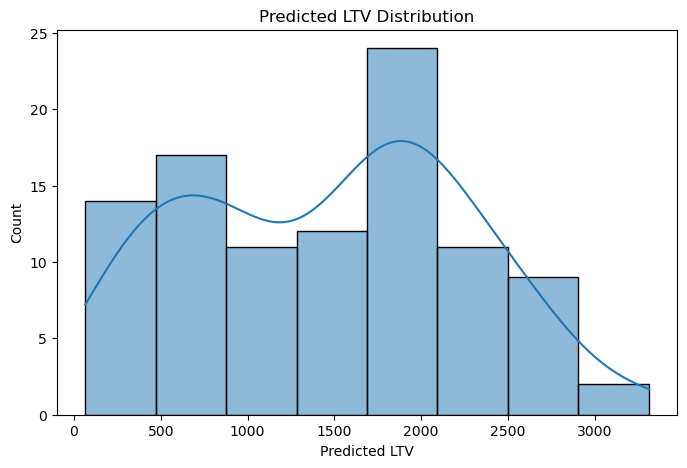

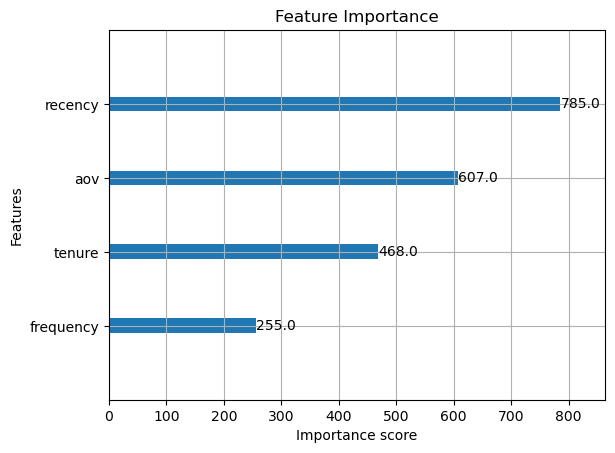

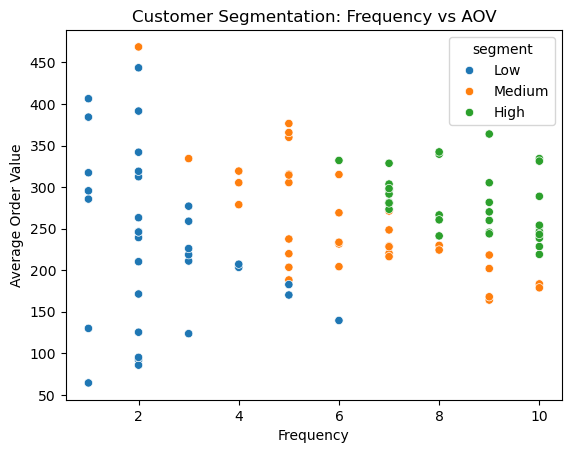

In [24]:
# Step 10: Visualizations

# 1. LTV Distribution
plt.figure(figsize=(8, 5))
sns.histplot(ltv_features['predicted_ltv'], kde=True)
plt.title("Predicted LTV Distribution")
plt.xlabel("Predicted LTV")
plt.ylabel("Count")
plt.show()

# 2. Feature Importance
xgb.plot_importance(model, importance_type='weight', max_num_features=10)
plt.title("Feature Importance")
plt.show()

# 3. Frequency vs AOV Scatter Plot by Segment
sns.scatterplot(data=ltv_features, x='frequency', y='aov', hue='segment')
plt.title("Customer Segmentation: Frequency vs AOV")
plt.xlabel("Frequency")
plt.ylabel("Average Order Value")
plt.show()


In [25]:
ltv_features.to_excel("ltv_predictions.xlsx", index=False)

